In [1]:
from zenbt.rs import LimitOrders, OrderType, Side
from data.data import read_data, download_okx_data
from zenbt.rs import Backtest, BacktestParams
from sdk.plotter import plot_equity


COMMISSION = 0
COMMISSION = 0.02 / 100
initial_capital = 2000

bt_params = BacktestParams(commission_pct=COMMISSION, initial_capital=initial_capital)

In [2]:
import os

print(os.getcwd())

/home/alpha/workspace/alphazen/zenbt


In [12]:
sym = "PEPE"
df, ohlcs = read_data(sym, 0, -1, resample_tf="1min", exchange="okx")

In [4]:
from strategy.atr import ATR_Strategy

st = ATR_Strategy(df, 100, (1, 2, 5, False))
bt = Backtest(ohlcs, bt_params, st.limit_orders)
bt.backtest()

In [13]:
from sdk.trade_record import get_trades_df

trades = get_trades_df(bt.get_state())
print(trades)

RS Time elapsed: 6.670985ms
     index  exit_index           entry_timestamp            exit_timestamp  \
0       94         134 2024-09-22 15:33:00+00:00 2024-09-22 16:13:00+00:00   
1      235         257 2024-09-22 17:54:00+00:00 2024-09-22 18:16:00+00:00   
2      217         258 2024-09-22 17:36:00+00:00 2024-09-22 18:17:00+00:00   
3      227         258 2024-09-22 17:46:00+00:00 2024-09-22 18:17:00+00:00   
4      290         305 2024-09-22 18:49:00+00:00 2024-09-22 19:04:00+00:00   
..     ...         ...                       ...                       ...   
381   5536        5711 2024-09-26 10:15:00+00:00 2024-09-26 13:10:00+00:00   
382   5711        5730 2024-09-26 13:10:00+00:00 2024-09-26 13:29:00+00:00   
383   5698        5733 2024-09-26 12:57:00+00:00 2024-09-26 13:32:00+00:00   
384   5694        5751 2024-09-26 12:53:00+00:00 2024-09-26 13:50:00+00:00   
385   5779        5790 2024-09-26 14:18:00+00:00 2024-09-26 14:29:00+00:00   

                entry_price        

In [30]:
from rich.table import Table
from rich.console import Console
from decimal import Decimal

data = bt.get_stats()["stats"]

# Create a console object
console = Console()

# Create a table
table = Table(title="Trading Summary")

# Add columns
table.add_column("Metric", justify="left", style="cyan", no_wrap=True)
table.add_column("Value", justify="right", style="magenta")

# Add rows from data
for key, value in data.items():
    table.add_row(key, str(value))

# Print the table
console.print(table)

                 Trading Summary                  
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric           ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ initial_capital  │                        2000 │
│ pnl              │ -0.000596889610821606035800 │
│ pnl_pct          │ -0.000029844480541080301790 │
│ unrealized_pnl   │     -0.00013398124405070200 │
│ total_positions  │                         402 │
│ closed_positions │                         386 │
│ active_positions │                          16 │
│ commissions      │  0.000131890638024335514400 │
│ wins             │                         238 │
│ losses           │                         148 │
│ win_rate         │                       61.66 │
│ trading_days     │                           4 │
│ start_date       │     2024-09-22 13:59:00 UTC │
│ end_date         │     2024-09-26 14:37:00 UTC │
│ max_drawdown     │  0.000820673644465729802000 │
│ max_drawdown_pct │  0.000041033682223286490100 │
└──────────────────┴─────────────────────────────┘

In [3]:
from data.data import read_data, read_data_pl
import time
import talib
from rich import print
import polars as pl
from zenbt.rs import (
    Strategy,
    BacktestParams,
    PySharedState,
    Backtest,
    Action,
    Order,
    Position,
    cross_above,
    cross_below,
)

from sdk.stats import Stats

from typing import Optional

COMMISSION = 0
COMMISSION = 0.02 / 100
initial_capital = 20000

bt_params = BacktestParams(commission_pct=COMMISSION, initial_capital=initial_capital)


class BaseStrategy(Strategy):
    index: int
    state: PySharedState

    def create_market_order(
        self,
        index,
        client_order_id: str,
        side: Side,
        size: float,
        sl: Optional[float] = None,
        tp: Optional[float] = None,
    ) -> Order:
        return Order(
            index=index,
            client_order_id=client_order_id,
            order_type=OrderType.Market,
            side=side,
            size=size,
            price=None,
            sl=sl,
            tp=tp,
        )

    # def active_long_positions(self) -> list[Position]:
    #     positions = []
    #     for pos in self.state.active_positions:
    #         if pos.side == Side.Long:
    #             positions.append(pos)
    #     return positions

    # def active_short_positions(self) -> list[Position]:
    #     positions = []
    #     for pos in self.state.active_positions:
    #         if pos.side == Side.Short:
    #             positions.append(pos)
    #     return positions

    # def has_position(self) -> bool:
    #     return len(self.state.active_positions) > 0


DefaultAction = Action(desired_positions={}, desired_orders={}, desired_position=None)
seen_pos = []


class ST(BaseStrategy):
    default_size = 1

    def on_candle_slow(self, index, state) -> Action:  # type: ignore
        fast_ma = self.data["fast_ma"]
        slow_ma = self.data["slow_ma"]

        desired_orders = {}
        desired_positions = {}
        # Check for bullish cross over
        if fast_ma[index - 1] < slow_ma[index - 1] and fast_ma[index] >= slow_ma[index]:
            # print("Going LONG at: ", index)
            order = self.create_market_order(
                index,
                client_order_id="Long",
                side=Side.Long,
                size=1,
                # sl=self.close * 0.99,
                # tp=self.close * 1.01,
            )
            desired_orders[order.client_order_id] = order
            desired_positions = {}

        # Check for bearish crossover
        if fast_ma[index - 1] > slow_ma[index - 1] and fast_ma[index] <= slow_ma[index]:
            # print("Going SHORT at: ", index)
            # print("Going short")
            order = self.create_market_order(
                index,
                client_order_id="Short",
                side=Side.Short,
                size=1,
                # sl=self.close * 1.01,
                # tp=self.close * 0.99,
            )
            desired_orders[order.client_order_id] = order
            desired_positions = {}

        return Action(
            desired_positions=desired_positions, desired_orders=desired_orders
        )

    def on_candle(self, index, state) -> Action:  # type: ignore
        # return self.on_candle_slow(index, state)
        cross_above = self.data["cross_above"][index]
        cross_below = self.data["cross_below"][index]
        desired_orders = {}
        desired_positions = {}
        desired_position = None

        if state.active_position:
            desired_position = state.active_position

        # Check for bullish cross over
        if cross_above:
            order = self.create_market_order(
                index,
                client_order_id="Long",
                side=Side.Long,
                size=self.default_size,
                # sl=self.close * 0.99,
                # tp=self.close * 1.01,
            )
            desired_orders[order.client_order_id] = order
            desired_positions = {}
            desired_position = None

        # Check for bearish crossover
        if cross_below:
            order = self.create_market_order(
                index,
                client_order_id="Short",
                side=Side.Short,
                size=self.default_size,
                # sl=self.close * 1.01,
                # tp=self.close * 0.99,
            )
            desired_orders[order.client_order_id] = order
            desired_positions = {}
            desired_position = None

        return Action(
            desired_positions=desired_positions,
            desired_orders=desired_orders,
            desired_position=desired_position,
        )

In [11]:
sym = "BTC"
df = read_data_pl(sym, 0, 200, resample_tf="1min", exchange="okx")

sym = "1000PEPE"
df = read_data_pl(sym, 0, -1, resample_tf="1min", exchange="binance")


start = time.time()
fast_ma = talib.SMA(df["close"], timeperiod=10)
slow_ma = talib.SMA(df["close"], timeperiod=50)
# atr = talib.ATR(df["high"], df["low"], df["close"], timeperiod=14)
df = df.with_columns(
    pl.Series("cross_above", cross_above(fast_ma, slow_ma)),
    pl.Series("cross_below", cross_below(fast_ma, slow_ma)),
)
st = ST(df)
st.default_size = 2
bt = Backtest(df, bt_params, st)

bt.backtest()
# print(f"Backtest with rows: {(time.time() - start) * 1000:.2f} ms")
# print(len(seen_pos))
# print(dir(bt.state))
stats = Stats(bt, df)

Number of total positions: 15828
Number of active positions: 0


In [12]:
stats.print()

start date: 2023-08-21 18:33:00 UTC
end date: 2024-09-05 18:27:00 UTC


               Trading Summary                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric           ┃                   Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ initial_capital  │                   20000 │
│ pnl              │              -0.0016162 │
│ pnl_pct          │            -0.000008081 │
│ unrealized_pnl   │                       0 │
│ total_positions  │                   15828 │
│ closed_positions │                   15828 │
│ active_positions │                       0 │
│ commissions      │           0.06558629720 │
│ wins             │                    7518 │
│ losses           │                    8310 │
│ win_rate         │                  47.50% │
│ trading_days     │                     380 │
│ start_date       │ 2023-08-21 18:33:00 UTC │
│ end_date         │ 2024-09-05 18:27:00 UTC │
│ max_drawdown     │               0.0052280 │
│ max_drawdown_pct │             0.000026140 │
└──────────────────┴─────────────────────────┘

shape: (549_000, 8)
┌───────────┬───────────┬───────────┬───────────┬────────────┬────────────┬────────────┬───────────┐
│ open      ┆ high      ┆ low       ┆ close     ┆ volume     ┆ time       ┆ cross_abov ┆ cross_bel │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---        ┆ e          ┆ ow        │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64        ┆ i64        ┆ ---        ┆ ---       │
│           ┆           ┆           ┆           ┆            ┆            ┆ bool       ┆ bool      │
╞═══════════╪═══════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╪═══════════╡
│ 0.0010771 ┆ 0.0010772 ┆ 0.0010762 ┆ 0.0010772 ┆ 5.7317677e ┆ 1692642780 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0010771 ┆ 0.0010771 ┆ 0.0010751 ┆ 0.0010759 ┆ 9.5397566e ┆ 1692642840 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0010758 ┆ 0.0010772 ┆ 0.0010757 ┆ 0.0010768 ┆ 7.5737944e ┆ 1692642900 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0010768 ┆ 0.0010776 ┆ 0.0010768 ┆ 0.0010776 ┆ 3.0924669e ┆ 1692642960 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0010776 ┆ 0.0010786 ┆ 0.0010772 ┆ 0.0010775 ┆ 4.5934659e ┆ 1692643020 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ …         ┆ …         ┆ …         ┆ …         ┆ …          ┆ …          ┆ …          ┆ …         │
│ 0.0071719 ┆ 0.0071753 ┆ 0.0071717 ┆ 0.0071718 ┆ 1.9119518e ┆ 1725560580 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0071719 ┆ 0.0071755 ┆ 0.0071704 ┆ 0.007173  ┆ 1.3642598e ┆ 1725560640 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0071727 ┆ 0.0071751 ┆ 0.0071681 ┆ 0.0071701 ┆ 1.1781343e ┆ 1725560700 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.00717   ┆ 0.0071743 ┆ 0.0071651 ┆ 0.0071691 ┆ 4.9544622e ┆ 1725560760 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆ 7          ┆ 000        ┆            ┆           │
│ 0.0071692 ┆ 0.0071748 ┆ 0.0071686 ┆ 0.0071698 ┆ 8.043884e6 ┆ 1725560820 ┆ false      ┆ false     │
│           ┆           ┆           ┆           ┆            ┆ 000        ┆            ┆           │
└───────────┴───────────┴───────────┴───────────┴────────────┴────────────┴────────────┴───────────┘

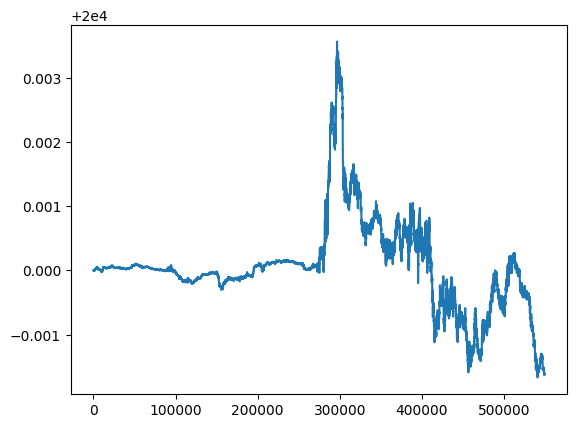

In [15]:
stats.equity["realized_equity"].plot()